In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
from numba import jit
from IPython import display
import warnings

warnings.resetwarnings()

def print_fl(x):
    print(x)
    sys.stdout.flush()

In [4]:
# simulation parameters
tau = 1e-2
delta_r = 1.0
c = 1
delta_t = 1/c
q = 7 # number of directions to be considered
num_iter = 10000
delta_u = np.array([0.01, 0.0])

rho = 1 
mass = 1

u_inlet = 0.004  # Velocity in lattice units.
omega = 1.0/(0.8)     # Relaxation parameter.
rho_inlet = 1.0

e = np.zeros((q,2))
e_angles = np.linspace(0,2*np.pi,6,endpoint=False)
e[0,:] = [0,0]                        # zero velocity vector
e[1:,0] = np.cos(e_angles)
e[1:,1] = np.sin(e_angles)

outflow_dir = 1

w_e = np.concatenate(([1/2], 1/12*np.ones(6)))

# bounce-back directions
bb_dir = np.concatenate(([0], 1 + ((np.arange(q-1) + (q-1)/2) % 6)))
bb_dir = np.array(bb_dir, dtype=np.int)

# directions going to the right
right_dirs = np.array([1,2,6], dtype=np.int)

/Users/jesse/anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/jesse/anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


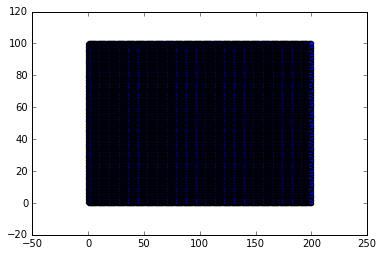

In [5]:
# generate grid (in this case triangular grid on rectangular domain)
L_x = 200
L_y = 101

template_x = np.arange(0, L_x, delta_r)
template_y = np.arange(0, L_y, 1/2*np.sqrt(3)*delta_r)

x_points = np.size(template_x)
y_points = np.size(template_y)
n_points = x_points*y_points

template_xi = np.arange(x_points, dtype=np.int)
template_yi = np.arange(y_points, dtype=np.int)

[grid_x, grid_y] = np.meshgrid(template_x, template_y, indexing='ij')
[grid_xi, grid_yi] = np.meshgrid(template_xi, template_yi, indexing='ij')
grid_x[:,::2] += (1/2)*delta_r

link_matrix = np.ones((x_points, y_points, 7, 2), dtype=np.int) * -1

# construct the link matrix by finding neighbours (invalid ones are removed later)
# stationary velocity
link_matrix[:,:,0,0] = (grid_xi) % x_points
link_matrix[:,:,0,1] = (grid_yi) % y_points

# +x direction
link_matrix[:,:,1,0] = (grid_xi[:,:]+1) % x_points
link_matrix[:,:,1,1] = (grid_yi[:,:]) % y_points

# up-right direction
link_matrix[:,::2,2,0] = (grid_xi[:,::2]+1) % x_points
link_matrix[:,1::2,2,0] = (grid_xi[:,1::2]) % x_points
link_matrix[:,:,2,1] = (grid_yi[:,:]+1) % y_points

# up-left direction
link_matrix[:,::2,3,0] = (grid_xi[:,::2]) % x_points
link_matrix[:,1::2,3,0] = (grid_xi[:,1::2]-1) % x_points
link_matrix[:,:,3,1] = (grid_yi[:,:]+1) % y_points

# -x direction
link_matrix[:,:,4,0] = (grid_xi[:,:]-1) % x_points
link_matrix[:,:,4,1] = (grid_yi[:,:]) % y_points

# down-left direction
link_matrix[:,::2,5,0] = (grid_xi[:,::2]) % x_points
link_matrix[:,1::2,5,0] = (grid_xi[:,1::2]-1) % x_points
link_matrix[:,:,5,1] = (grid_yi[:,:]-1) % y_points

# down-right direction
link_matrix[:,::2,6,0] = (grid_xi[:,::2]+1) % x_points
link_matrix[:,1::2,6,0] = (grid_xi[:,1::2]) % x_points
link_matrix[:,:,6,1] = (grid_yi[:,:]-1) % y_points

# reshape lattice into a list
lattice = np.zeros((n_points,2))

lattice[:,0] = grid_x.reshape(n_points)
lattice[:,1] = grid_y.reshape(n_points)

# clean up invalid links
link_matrix_inv_x = (link_matrix[:,:,:,0] >= x_points) | (link_matrix[:,:,:,0] < 0)
link_matrix_inv_y = (link_matrix[:,:,:,1] >= y_points) | (link_matrix[:,:,:,1] < 0)

link_matrix_inv = link_matrix_inv_x | link_matrix_inv_y

link_matrix[link_matrix_inv,:] = -1

# transform link matrix into a flat list that corresponds to the lattice list
link_list = (link_matrix[:,:,:,0] * y_points + link_matrix[:,:,:,1]).reshape((n_points), 7)
link_list[link_list < 0] = -1

plt.scatter(lattice[:,0], lattice[:,1])
plt.show()

    @jit(nopython=True)
    def construct_link_list(lattice,e,link_list):
        q = e.shape[0]
        n_points = lattice.shape[0]
        tol = 1e-10

        for k in range(q):
            candidate_rs = lattice + e[k,:]
            for i in range(n_points):
                close_rs = np.abs(lattice - candidate_rs[i,:]) < tol
                candidates = close_rs[:,0] & close_rs[:,1]
                candidate_i = np.argmax(candidates)
                # we have to check this, as there may not be a neighbour in this direction at all
                if candidates[candidate_i] == True:
                    link_list[i,k] = candidate_i

        return link_list

    link_list_t = np.ones((n_points, q), dtype=np.int) * -1
    link_list = construct_link_list(lattice, e, link_list_t)

    %timeit link_list = construct_link_list(lattice, e, link_list_t)

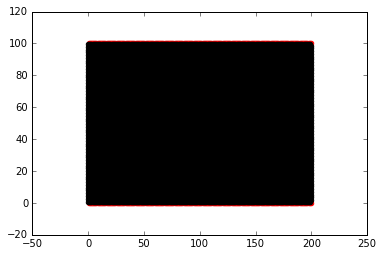

In [6]:
# identify different types of nodes
lower_wall_i = np.flatnonzero(lattice[:,1] == template_y[0])
upper_wall_i = np.flatnonzero(lattice[:,1] == template_y[-1])
bc_noslip_i = np.concatenate((lower_wall_i, upper_wall_i))

#bc_left_wall_i = np.flatnonzero(lattice[:,0] < (template_x[0] + 3/4*delta_r))
#bc_right_wall_i = np.flatnonzero(lattice[:,0] > (template_x[-1] - 1/4*delta_r))

# remove conflicting points that have multiple boundary identities
#bc_left_wall_i = np.setdiff1d(bc_left_wall_i, np.intersect1d(bc_left_wall_i, bc_noslip_i))
#bc_right_wall_i = np.setdiff1d(bc_right_wall_i, np.intersect1d(bc_right_wall_i, bc_noslip_i))

boundary_i = np.copy(bc_noslip_i)
interior_i = np.setdiff1d(np.arange(n_points), boundary_i)

plt.figure()
plt.scatter(lattice[bc_noslip_i, 0], lattice[bc_noslip_i, 1], color='r')
#plt.scatter(lattice[bc_left_wall_i, 0], lattice[bc_left_wall_i, 1], color='b')
#plt.scatter(lattice[bc_right_wall_i, 0], lattice[bc_right_wall_i, 1], color='g')
plt.scatter(lattice[interior_i, 0], lattice[interior_i, 1], color='k')
plt.show()

In [7]:
# adjust linkage of boundary cells

link_list[lower_wall_i,5] = -1
link_list[lower_wall_i,6] = -1

link_list[upper_wall_i,2] = -1
link_list[upper_wall_i,3] = -1

In [8]:
plot_links = False

if plot_links:
    direc = 6
    plt.figure()
    for i in range(n_points):
        if(link_list[i,direc] != -1):
            x1 = lattice[i,0]
            y1 = lattice[i,1]

            x2 = lattice[link_list[i,direc],0]
            y2 = lattice[link_list[i,direc],1]

            plt.arrow(x1, y1, (x2-x1)/2, (y2-y1)/2, head_width=0.2, head_length=0.2)

    plt.scatter(lattice[:,0], lattice[:,1])
    plt.show()

In [9]:
np.size(link_list)

163800

In [10]:
f_prev = np.zeros((n_points, q))
f_next = np.zeros((n_points, q))

f_eq = np.zeros((n_points, q))

def calc_f_eq(rho, u, e, w_e, c):
    ue = np.dot(u, np.transpose(e))
    uu = np.sum(u*u, axis=1)
    uuee = ue*ue
    
    f_eq = w_e[np.newaxis,:] * rho[:,np.newaxis] * (1 + 4*ue/(c**2) - 2*uu[:,np.newaxis]/(c**2) + 8*uuee/(c**4))
    return f_eq

In [11]:
initial_u = np.zeros((n_points, 2))
#initial_u[interior_i,0] = u_inlet
#initial_u[bc_left_wall_i,0] = u_inlet
#initial_u[bc_right_wall_i,0] = u_inlet

initial_rho = np.ones((n_points)) * rho_inlet
initial_rho[bc_noslip_i] = 0.0
#initial_rho[interior_i] = rho_inlet
#initial_rho[bc_left_wall_i] = rho_inlet
#initial_rho[bc_right_wall_i] = rho_inlet

f_prev[:,:] = calc_f_eq(initial_rho, initial_u, e, w_e, c)

#f_prev[:,:] = 0.0
#f_prev[bc_left_wall_i,right_dirs] = calc_f_eq(initial_rho, initial_u[:,:], e, w_e, c)[bc_left_wall_i,right_dirs]

#f_prev[bc_left_wall_i.reshape(-1,1),right_dirs] = calc_f_eq(initial_rho, initial_u[:,:], e, w_e, c)[bc_left_wall_i.reshape(-1,1),right_dirs]

#f_prev[bc_noslip_i, ]

In [12]:
warnings.simplefilter("error")

visualize = False

if visualize == True:
    fig = plt.figure()
    ax = fig.gca()
    
t = 0

u = np.zeros((n_points, 2))

for t in range(num_iter):
    # clear distribution
    f_next[:,:] = 0
    
    # right wall boundary condition: outflow condition
    #f_prev[bc_right_wall_i, :] = f_prev[link_list[bc_right_wall_i, bb_dir[outflow_dir]], :]
    
    # calculate macroscopic quantities
    # density: sum distribution over velocities
    rho = np.sum(f_prev, axis=1)
    # velocity: calculate weighted sum of velocities using distributions
    has_rho = rho > 0
    u[:,:] = 0.0
    u[has_rho,:] = (np.dot(f_prev, e)[has_rho,:])/rho[has_rho,np.newaxis]
    
    # add a little velocity
    u[:,:] += delta_u
    
    # left wall boundary condition: constant velocity inlet
    #rho[bc_left_wall_i] = initial_rho[bc_left_wall_i]
    #u[bc_left_wall_i] = initial_u[bc_left_wall_i]
    
    # calculate equilibrium
    f_eq[:,:] = calc_f_eq(rho, u, e, w_e, c)
    
    # apply left wall bc distribution
    # f_prev[bc_left_wall_i.reshape(-1,1),right_dirs] = f_eq[bc_left_wall_i.reshape(-1,1),right_dirs]
    
    # collision step
    f_prev[interior_i,:] = f_prev[interior_i,:] - omega * (f_prev[interior_i,:] - f_eq[interior_i,:])
    
    # streaming step
    for i in range(q):
        # we have to filter out the invalid links 
        valid_links = link_list[:,i] > -1
        f_next[link_list[valid_links,i],i] = f_prev[valid_links,i]
    
    # top and bottom wall boundary condition: no slip/bounce-back
    f_next[bc_noslip_i.reshape(-1,1), bb_dir[np.arange(q)]] = f_next[bc_noslip_i.reshape(-1,1), np.arange(q)]
        
    # finish the iteration
    f_prev[:,:] = f_next[:,:]
    
    
    if visualize == True:
        ax.cla()
        #ax.pcolor(lattice[:,0], lattice[:,1], rho)
        ax.scatter(lattice[:,0], lattice[:,1])
        ax.quiver(lattice[:,0], lattice[:,1], u[:,0], u[:,1])
        display.clear_output(wait=True)
        display.display(fig)
        
    if t % int(0.1*num_iter) == 0:
        print_fl(r"Simulation progress: %.1f%%" % (t/num_iter * 100.0) )
        #print_fl(rho[lower_wall_i])
        
if visualize == True:
    display.clear_output()
    
print_fl("Finished")

warnings.resetwarnings()

Simulation progress: 0.0%
Simulation progress: 10.0%
Simulation progress: 20.0%
Simulation progress: 30.0%
Simulation progress: 40.0%
Simulation progress: 50.0%
Simulation progress: 60.0%
Simulation progress: 70.0%
Simulation progress: 80.0%
Simulation progress: 90.0%
Finished


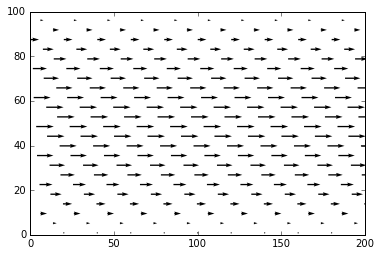

In [13]:
plt.quiver(lattice[interior_i,0][::100], lattice[interior_i,1][::100], u[interior_i,0][::100], u[interior_i,1][::100])

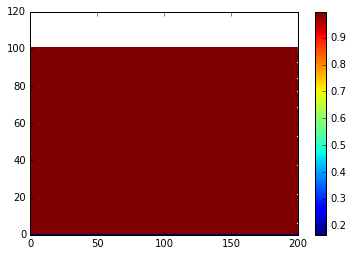

In [14]:
plt.pcolor(grid_x, grid_y, rho.reshape(grid_x.shape))
plt.colorbar()

plt.show()

In [20]:
u_grid = u.reshape(x_points,y_points,2)

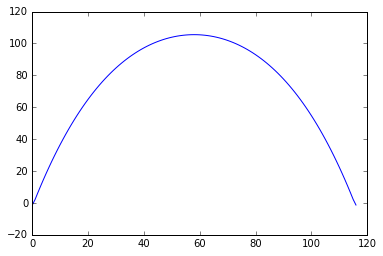

In [21]:
plt.plot(u_grid[0,:,0])